In [1]:
# Imports

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

## 1. Load and Clean Data 

In the first step we need to load and clean our data

In [2]:
vax_rates = pd.read_csv('COVID-19_vaccination_rates.csv') 
vax_rates = vax_rates.loc[(vax_rates["date"]=="2021-10-25")]
vax_rates = vax_rates[["location","people_fully_vaccinated_per_hundred"]]
vax_rates.rename(columns={'location': 'Country Name'}, inplace=True)
vax_rates = vax_rates.loc[(vax_rates["people_fully_vaccinated_per_hundred"]==vax_rates["people_fully_vaccinated_per_hundred"])]
vax_rates.head()

,Country Name,people_fully_vaccinated_per_hundred
568,Africa,5.53
901,Albania,30.57
2713,Argentina,55.56
3219,Aruba,71.37
3578,Asia,41.54


In [3]:
# Create c_map
codes = pd.read_csv('country_codes.csv')

lookup_table = codes[['Alpha-3 code','Country']]

# Lookup table to dict
c_map = {}
for i, t in lookup_table.iterrows():
    key = t[0][2:5]
    val = t[1]
    
    c_map[key] = val

In [4]:
trust_in_gov = pd.read_csv('trust_in_government.csv') 
    
# enhance government trust df
trust_in_gov = trust_in_gov.assign(country=trust_in_gov['LOCATION'].map(c_map))
 
trust_in_gov = trust_in_gov.loc[(trust_in_gov["TIME"]==2019)][["country","Value"]]
trust_in_gov.rename(columns={"Value": "trust_in_government_2019"}, inplace=True)
trust_in_gov.rename(columns={"country": "Country Name"}, inplace=True)
trust_in_gov.head()

,Country Name,trust_in_government_2019
12,Australia,46.870001
26,Austria,51.233826
40,Belgium,32.790115
55,Canada,54.928097
83,Denmark,63.299903


In [5]:
gdp = pd.read_csv('gdp_per_capita.csv') 
gdp = gdp[["Country Name","2020"]]
gdp.rename(columns={'2020': 'gdp_per_capita_2020'}, inplace=True)
gdp = gdp.loc[(gdp["gdp_per_capita_2020"]==gdp["gdp_per_capita_2020"])]
gdp = gdp.set_index('Country Name')
gdp.head()

,gdp_per_capita_2020
Country Name,
Africa Eastern and Southern,3677.111255
Afghanistan,2077.874554
Africa Western and Central,4240.534782
Angola,6443.032680
Albania,13899.933981


In [6]:
secondary_edu = pd.read_csv('secondary_education.csv')  
secondary_edu = secondary_edu.loc[(secondary_edu["TIME"]==2019)].loc[(secondary_edu["SUBJECT"]=="UPPSRY")][["LOCATION","Value"]]
secondary_edu.rename(columns={"Value": "secondary_education_2019"}, inplace=True)
        
# enhance government trust df
secondary_edu = secondary_edu.assign(country=secondary_edu['LOCATION'].map(c_map))
secondary_edu = secondary_edu[['country', 'secondary_education_2019']]
secondary_edu.rename(columns={"country": "Country Name"}, inplace=True)

secondary_edu = secondary_edu.dropna()
secondary_edu.head()

,Country Name,secondary_education_2019
9,Austria,77.636
33,Belgium,77.047
50,Canada,84.317
79,Czech Republic,80.510
104,Denmark,81.629


In [7]:
tert_edu = pd.read_csv('tertiary_education.csv')[["LOCATION","SUBJECT", "TIME", "Value"]]
tert_edu = tert_edu.loc[(tert_edu["TIME"]==2019)].loc[(tert_edu["SUBJECT"]=="BACHR_MEN")|(tert_edu["SUBJECT"]=="BACHR_WOMEN")]
tert_edu.rename(columns={"Value": "tertiary_education_2019"}, inplace=True)

tert_edu = tert_edu.pivot(index="LOCATION", columns="SUBJECT", values="tertiary_education_2019")
tert_edu['tertiary_education_2019'] = tert_edu["BACHR_MEN"] + tert_edu['BACHR_WOMEN']
tert_edu = tert_edu["tertiary_education_2019"].to_frame()
tert_edu = tert_edu.reset_index() 
        
# enhance government trust df
tert_edu = tert_edu.assign(country=tert_edu['LOCATION'].map(c_map))
tert_edu.rename(columns={"country": "Country Name"}, inplace=True)

tert_edu = tert_edu[['Country Name', 'tertiary_education_2019']]
tert_edu.head()

,Country Name,tertiary_education_2019
0,Australia,69.343
1,Austria,37.418
2,Belgium,80.736
3,Switzerland,72.556
4,Chile,52.185


In [8]:
cov_data = pd.read_csv('./worldwide_covid_data.csv')
cov_deaths = cov_data.rename(columns={'Country':'location'})[['location','Deaths/1M population']]
cov_deaths.rename(columns={"location": "Country Name"}, inplace=True)

cov_deaths.head()

,Country Name,Deaths/1M population
0,Afghanistan,182
1,Albania,1034
2,Algeria,133
3,Andorra,1679
4,Angola,50


In [9]:
betterlife = pd.read_csv('./betterlifeindex_2019.csv')

health = betterlife 
health.rename(columns={"Country": "Country Name"}, inplace=True)
health = health[["LOCATION", "Country Name","Indicator", "Value"]].loc[(health["Inequality"]=="Total")]
health = health.loc[(health["Indicator"]=="Self-reported health")][["Country Name", "Value"]]
health.rename(columns={"Value": "Self-reported_health_2019"}, inplace=True)
health.head()

,Country Name,Self-reported_health_2019
1636,Australia,85.0
1637,Austria,70.0
1638,Belgium,74.0
1639,Canada,88.0
1640,Czech Republic,60.0


In [10]:
life_exp = betterlife.loc[(betterlife["Indicator"]=="Life expectancy")][["Country Name", "LOCATION", "Value"]]
life_exp.rename(columns={"Value": "Life_expectancy_2019"}, inplace=True)
#life_exp = life_exp.set_index('Country Name')
life_exp = life_exp[['Life_expectancy_2019', 'Country Name']]
life_exp.head()

,Life_expectancy_2019,Country Name
1519,82.5,Australia
1520,81.7,Austria
1521,81.5,Belgium
1522,81.9,Canada
1523,79.1,Czech Republic


In [11]:
work = betterlife.loc[(betterlife["Indicator"]=="Employees working very long hours")][["Country Name", "LOCATION", "Value"]]
work.rename(columns={"Value": "Employees_working_hours_2019"}, inplace=True)
work = work[['Country Name','Employees_working_hours_2019']]
work.head()

,Country Name,Employees_working_hours_2019
2090,Australia,13.04
2091,Austria,6.66
2092,Belgium,4.75
2093,Canada,3.69
2094,Czech Republic,5.65


In [12]:
unemp = pd.read_csv('unemployment_rate.csv') 
unemp = unemp[["Country Name","2020"]] # select and reduce
unemp.rename(columns={"2020": "unemployment_2020"}, inplace=True)
unemp = unemp.loc[(unemp["unemployment_2020"]==unemp["unemployment_2020"])]
unemp.head()

,Country Name,unemployment_2020
1,Africa Eastern and Southern,6.814177
2,Afghanistan,11.730000
3,Africa Western and Central,6.300105
4,Angola,7.700000
5,Albania,11.700000


## 2. analyse vaccination rate with each of the other factors

    In the second step we analyse the correlation and the scatter plot of each factor with the vaccination rate

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

import scipy

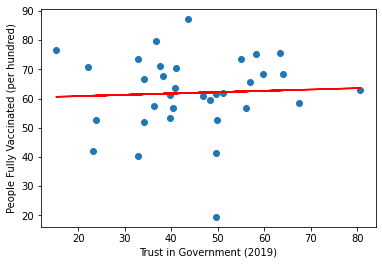

r: 0.04876726212710701
(0.048767262127107074, 0.7841720802236305)


In [14]:
#### TRUST IN GOVERNMENT ######
trust_x_vax = pd.merge(trust_in_gov, vax_rates, on=["Country Name"])
trust_x_vax_r = trust_x_vax.corr().iloc[0,1]

linear_regressor = LinearRegression()  # create object for the class
X = trust_x_vax['trust_in_government_2019'].values.reshape(-1, 1)
Y =  trust_x_vax['people_fully_vaccinated_per_hundred'].values.reshape(-1, 1)
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.scatter(X,Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('Trust in Government (2019)')
plt.ylabel('People Fully Vaccinated (per hundred)')
plt.show()
print("r: {}".format(trust_x_vax_r))

print(scipy.stats.pearsonr(X.flatten(), Y.flatten()))


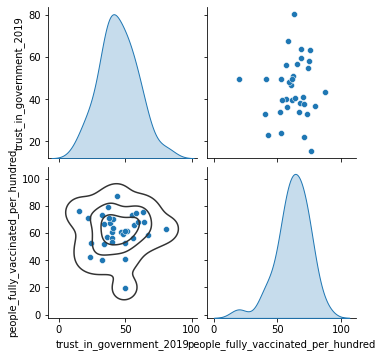

In [15]:
g = sns.pairplot(trust_x_vax, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

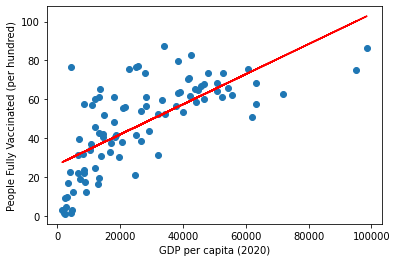

r: 0.7006793183652771
(0.7006793183652773, 7.542031256159133e-15)


In [16]:
#### GDP ######
gdp_x_vax = pd.merge(gdp, vax_rates, on=["Country Name"])
gdp_x_vax_r = gdp_x_vax.corr().iloc[0,1]

linear_regressor = LinearRegression()  # create object for the class
X = gdp_x_vax['gdp_per_capita_2020'].values.reshape(-1, 1)
Y =  gdp_x_vax['people_fully_vaccinated_per_hundred'].values.reshape(-1, 1)
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.scatter(X,Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('GDP per capita (2020)')
plt.ylabel('People Fully Vaccinated (per hundred)')
plt.show()
print("r: {}".format(gdp_x_vax_r))

print(scipy.stats.pearsonr(X.flatten(), Y.flatten()))

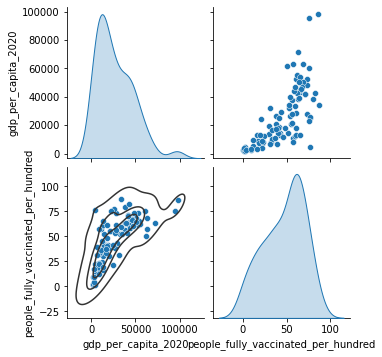

In [17]:
g = sns.pairplot(gdp_x_vax, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

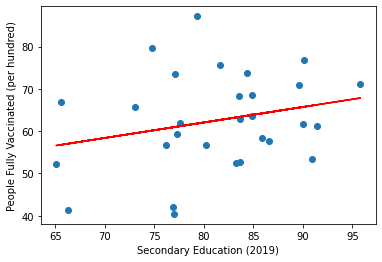

r: 0.24994288969897402
(0.24994288969897396, 0.19099301978906152)


In [18]:
#### secondary education ######
edu2_x_vax = pd.merge(secondary_edu, vax_rates, on=["Country Name"])
edu2_x_vax_r = edu2_x_vax.corr().iloc[0,1]

linear_regressor = LinearRegression()  # create object for the class
X = edu2_x_vax['secondary_education_2019'].values.reshape(-1, 1)
Y =  edu2_x_vax['people_fully_vaccinated_per_hundred'].values.reshape(-1, 1)
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.scatter(X,Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('Secondary Education (2019)')
plt.ylabel('People Fully Vaccinated (per hundred)')
plt.show()


print("r: {}".format(edu2_x_vax_r))

print(scipy.stats.pearsonr(X.flatten(), Y.flatten()))

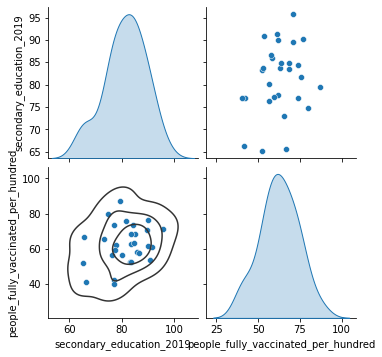

In [19]:
g = sns.pairplot(edu2_x_vax, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

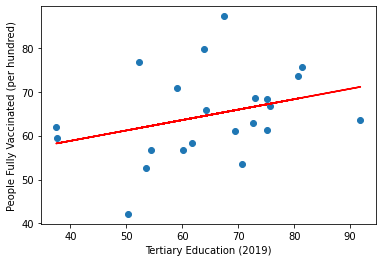

r: 0.24994288969897402
(0.320275896778003, 0.14618472314374167)


In [20]:
#### tertiary education ######
edu3_x_vax = pd.merge(tert_edu, vax_rates, on=["Country Name"])
edu3_x_vax_r = edu3_x_vax.corr().iloc[0,1]

linear_regressor = LinearRegression()  # create object for the class
X = edu3_x_vax['tertiary_education_2019'].values.reshape(-1, 1)
Y =  edu3_x_vax['people_fully_vaccinated_per_hundred'].values.reshape(-1, 1)
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.scatter(X,Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('Tertiary Education (2019)')
plt.ylabel('People Fully Vaccinated (per hundred)')
plt.show()

print("r: {}".format(edu2_x_vax_r))

print(scipy.stats.pearsonr(X.flatten(), Y.flatten()))

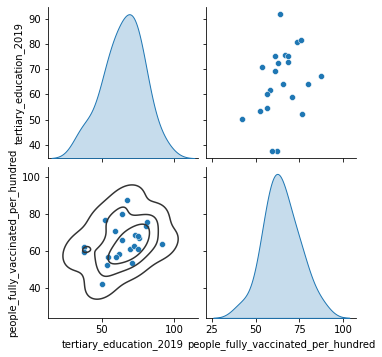

In [21]:
g = sns.pairplot(edu3_x_vax, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

In [22]:
#### COVID deaths ######
data = pd.merge(cov_deaths, vax_rates, on=["Country Name"])
data

,Country Name,Deaths/1M population,people_fully_vaccinated_per_hundred
0,Albania,1034,30.57
1,Argentina,2539,55.56
2,Aruba,1602,71.37
3,Australia,71,61.01
4,Austria,1273,62.03
...,...,...,...
85,Turkey,847,56.70
86,Ukraine,1692,16.29
87,Uruguay,1746,75.40
88,Vietnam,230,22.23


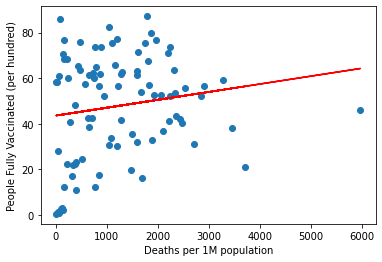

r: 0.1592120124198245
(0.1592120124198245, 0.13390397233263593)


In [23]:
#### COVID DEATHS ######
deaths_x_vax = pd.merge(cov_deaths, vax_rates, on=["Country Name"])
deaths_x_vax_r = deaths_x_vax.corr().iloc[0,1]


linear_regressor = LinearRegression()  # create object for the class
X = deaths_x_vax['Deaths/1M population'].values.reshape(-1, 1)
Y =  deaths_x_vax['people_fully_vaccinated_per_hundred'].values.reshape(-1, 1)
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.scatter(X,Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('Deaths per 1M population')
plt.ylabel('People Fully Vaccinated (per hundred)')
plt.show()


print("r: {}".format(deaths_x_vax_r))

print(scipy.stats.pearsonr(X.flatten(), Y.flatten()))

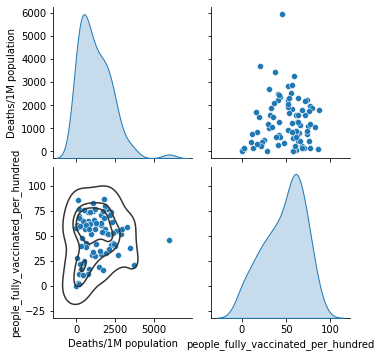

In [24]:
g = sns.pairplot(deaths_x_vax, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

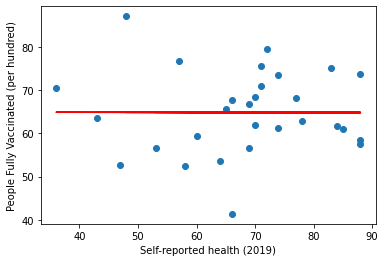

r: -0.001801243803389101
(-0.0018012438033885199, 0.9926010814764531)


In [25]:
#### SELF REPORTED HEALTH ######
health_x_vax = pd.merge(health, vax_rates, on=["Country Name"])
health_x_vax_r = health_x_vax.corr().iloc[0,1]


linear_regressor = LinearRegression()  # create object for the class
X = health_x_vax['Self-reported_health_2019'].values.reshape(-1, 1)
Y =  health_x_vax['people_fully_vaccinated_per_hundred'].values.reshape(-1, 1)
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.scatter(X,Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('Self-reported health (2019)')
plt.ylabel('People Fully Vaccinated (per hundred)')
plt.show()

print("r: {}".format(health_x_vax_r))

print(scipy.stats.pearsonr(X.flatten(), Y.flatten()))

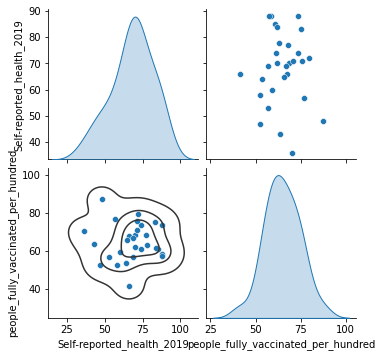

In [26]:
g = sns.pairplot(health_x_vax, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

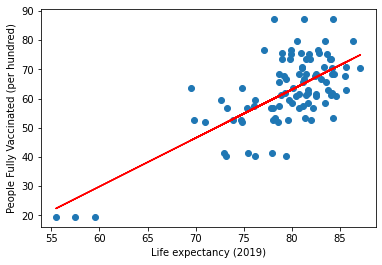

r: 0.7005447860101955
(0.7005447860101951, 1.9473619368306095e-15)


In [27]:
#### life expectancy ######
life_exp_x_vax = pd.merge(life_exp, vax_rates, on=["Country Name"])
life_exp_x_vax_r = life_exp_x_vax.corr().iloc[0,1]

linear_regressor = LinearRegression()  # create object for the class
X = life_exp_x_vax['Life_expectancy_2019'].values.reshape(-1, 1)
Y =  life_exp_x_vax['people_fully_vaccinated_per_hundred'].values.reshape(-1, 1)
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.scatter(X,Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('Life expectancy (2019)')
plt.ylabel('People Fully Vaccinated (per hundred)')
plt.show()

print("r: {}".format(life_exp_x_vax_r))

print(scipy.stats.pearsonr(X.flatten(), Y.flatten()))

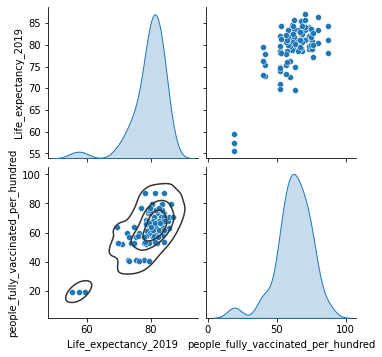

In [28]:
g = sns.pairplot(life_exp_x_vax, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

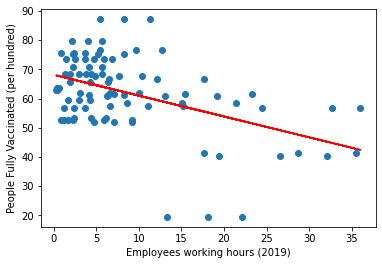

r: -0.46449035419838264
(-0.4644903541983827, 2.7308746227520226e-06)


In [29]:
#### very long working hours ######
work_x_vax = pd.merge(work, vax_rates, on=["Country Name"])
work_x_vax_r = work_x_vax.corr().iloc[0,1]

linear_regressor = LinearRegression()  # create object for the class
X = work_x_vax['Employees_working_hours_2019'].values.reshape(-1, 1)
Y =  work_x_vax['people_fully_vaccinated_per_hundred'].values.reshape(-1, 1)
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.scatter(X,Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('Employees working hours (2019)')
plt.ylabel('People Fully Vaccinated (per hundred)')
plt.show()

print("r: {}".format(work_x_vax_r))

print(scipy.stats.pearsonr(X.flatten(), Y.flatten()))

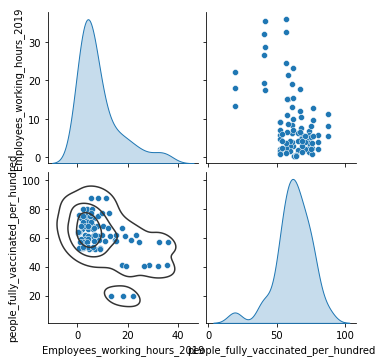

In [30]:
g = sns.pairplot(work_x_vax, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

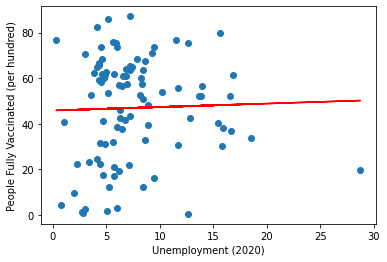

r: 0.030435560053394487
(0.03043556005339452, 0.772116629483641)


In [31]:
#### unemployment ######
unemp_x_vax = pd.merge(unemp, vax_rates, on=["Country Name"])
unemp_x_vax_r = unemp_x_vax.corr().iloc[0,1]

linear_regressor = LinearRegression()  # create object for the class
X = unemp_x_vax['unemployment_2020'].values.reshape(-1, 1)
Y =  unemp_x_vax['people_fully_vaccinated_per_hundred'].values.reshape(-1, 1)
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.scatter(X,Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('Unemployment (2020)')
plt.ylabel('People Fully Vaccinated (per hundred)')
plt.show()


print("r: {}".format(unemp_x_vax_r))

print(scipy.stats.pearsonr(X.flatten(), Y.flatten()))

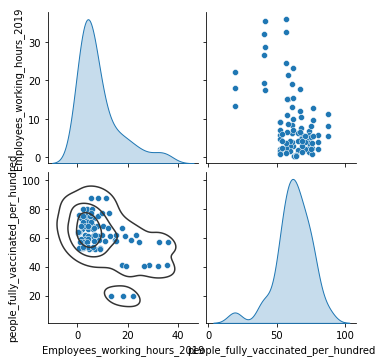

In [32]:
g = sns.pairplot(work_x_vax, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

In [33]:
### Plot all data ###### -> outer join

In [34]:
data = pd.merge(vax_rates, trust_in_gov, on=["Country Name"], how='outer')
data = pd.merge(data, gdp, on=["Country Name"], how='outer')
data = pd.merge(data, secondary_edu, on=["Country Name"], how='outer')
data = pd.merge(data, tert_edu, on=["Country Name"], how='outer')
data = pd.merge(data, cov_deaths, on=["Country Name"], how='outer')
data = pd.merge(data, health, on=["Country Name"], how='outer')
data = pd.merge(data, life_exp, on=["Country Name"], how='outer')
data = pd.merge(data, work, on=["Country Name"], how='outer')
data = pd.merge(data, unemp, on=["Country Name"], how='outer')

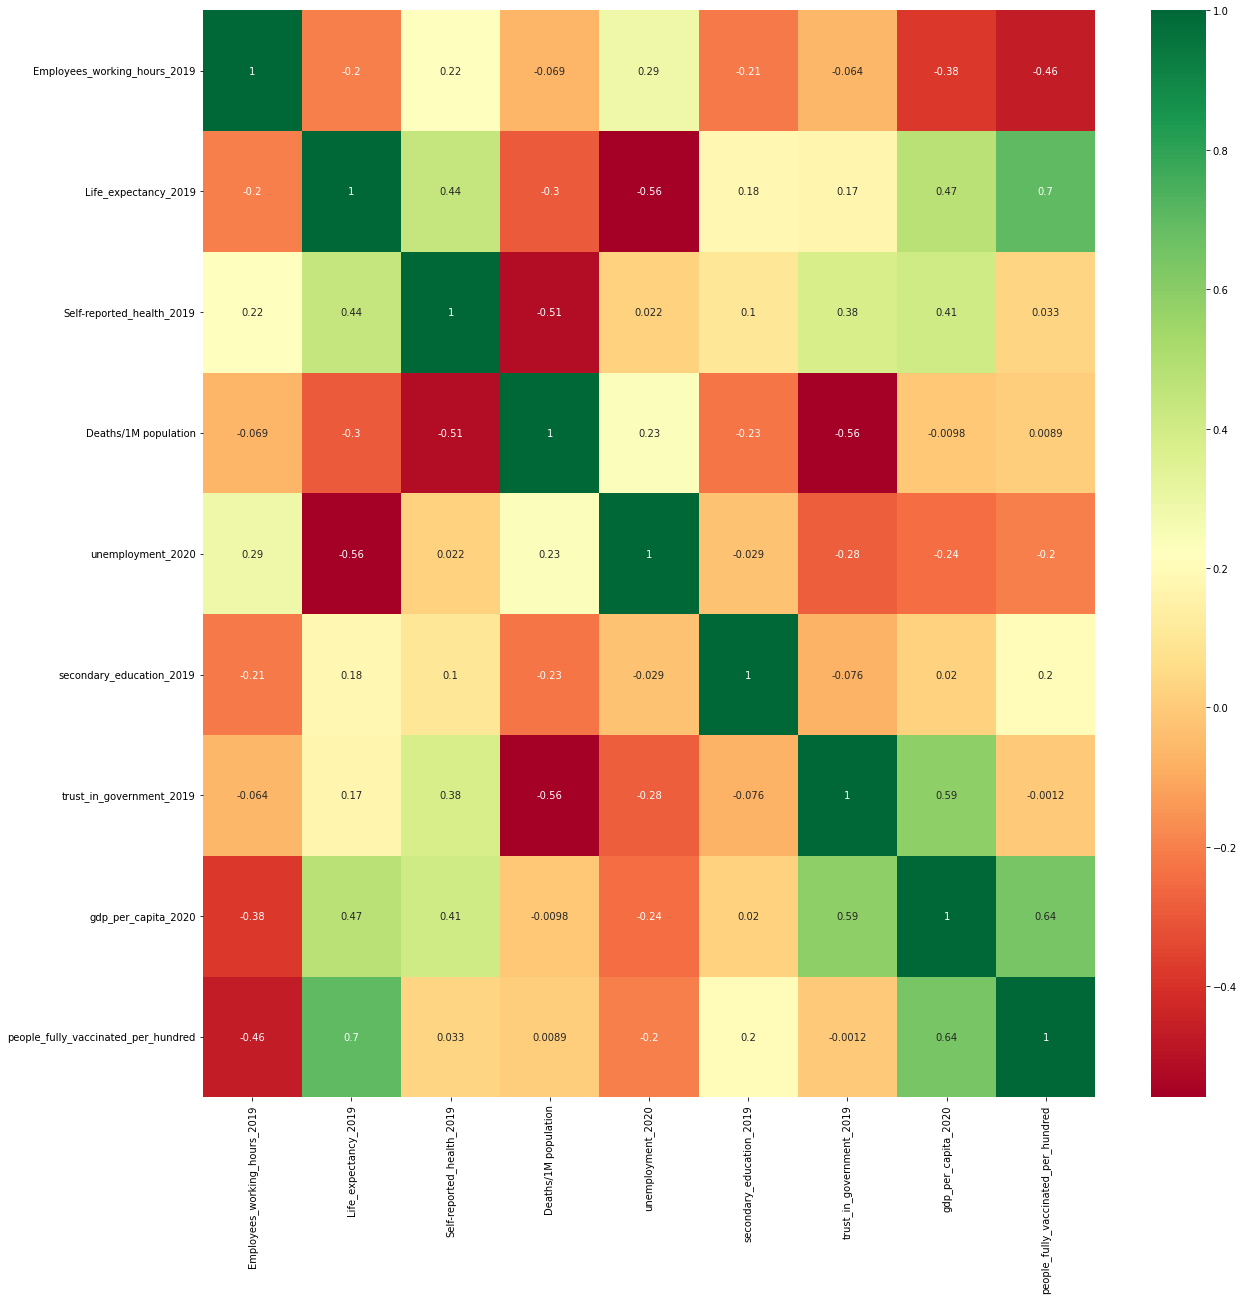

In [35]:
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[["Employees_working_hours_2019", "Life_expectancy_2019", "Self-reported_health_2019","Deaths/1M population", "unemployment_2020","secondary_education_2019","trust_in_government_2019", "gdp_per_capita_2020", "people_fully_vaccinated_per_hundred"]].corr(),annot=True,cmap="RdYlGn")

In [36]:
#https://seaborn.pydata.org/generated/seaborn.pairplot.html#seaborn.pairplot

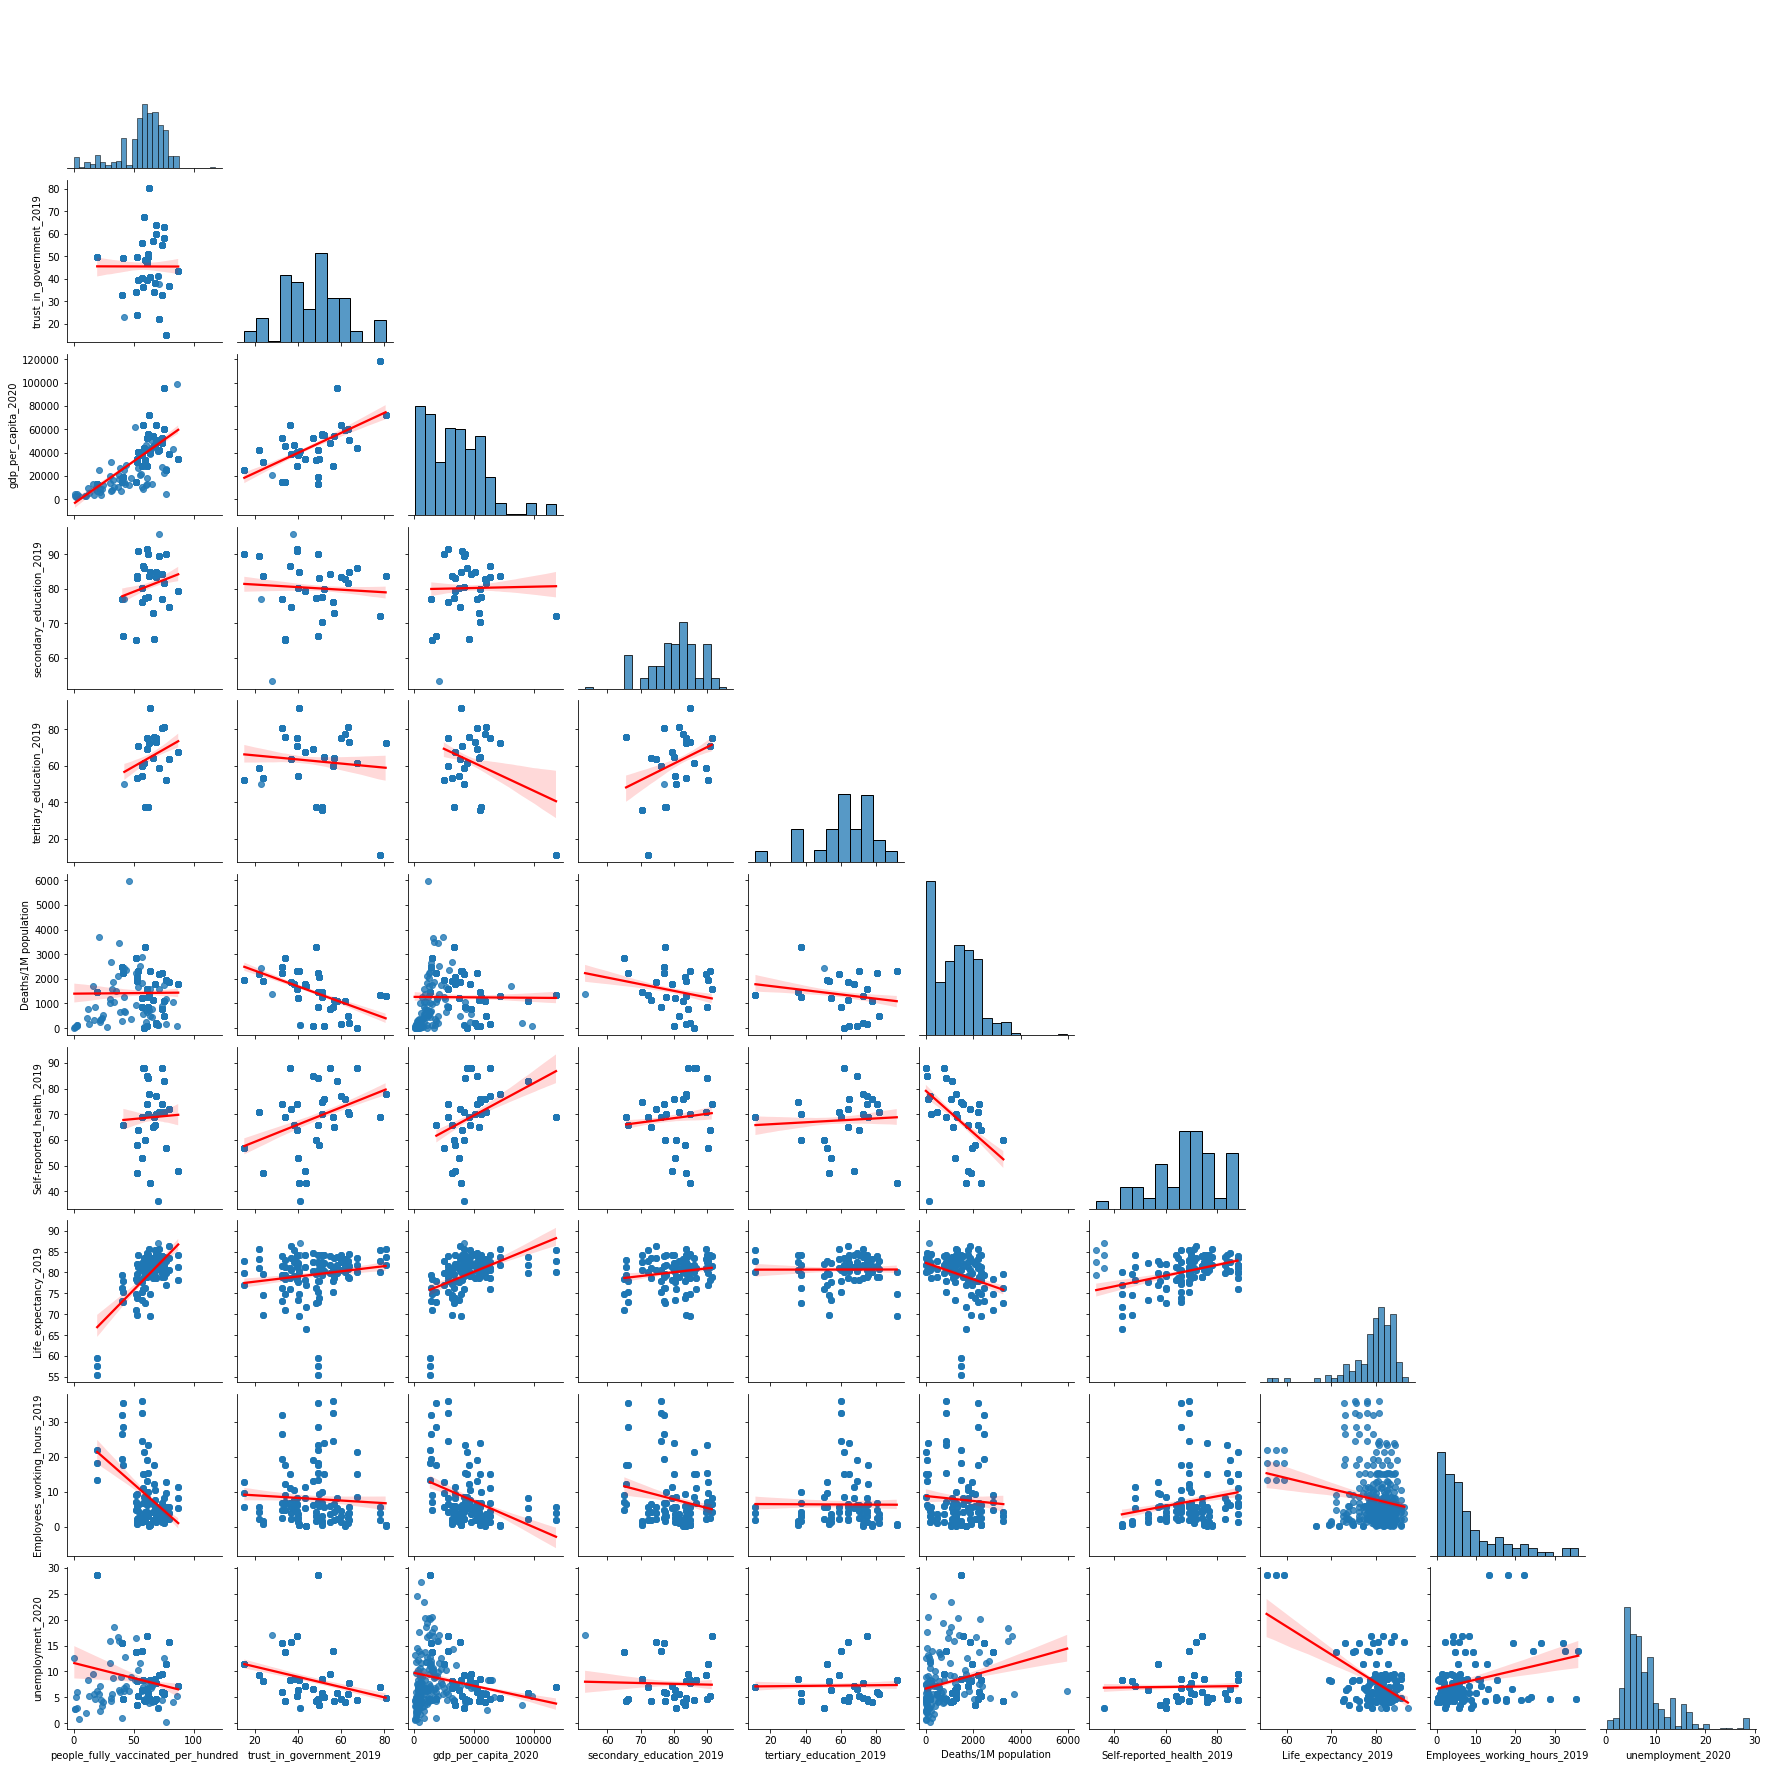

In [41]:
#sns.pairplot(data, corner=True)

g = sns.pairplot(data, kind="reg", corner=True, plot_kws={'line_kws':{'color':'red'}})
plt.show()

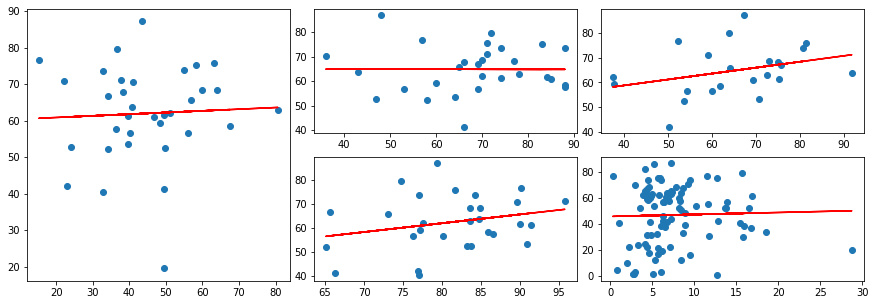

In [40]:
# Plot features like this but with high corr features on the big plots and low corr plots on small plos

figure_mosaic = '''
AABBDD
AACCEE
'''
linear_regressor = LinearRegression()  # create object for the class
X_trust = trust_x_vax['trust_in_government_2019'].values.reshape(-1, 1)
Y_trust =  trust_x_vax['people_fully_vaccinated_per_hundred'].values.reshape(-1, 1)
linear_regressor.fit(X_trust,Y_trust)  # perform linear regression
Y_pred_trust = linear_regressor.predict(X_trust)  # make predictions


linear_regressor = LinearRegression()  # create object for the class
X_health = health_x_vax['Self-reported_health_2019'].values.reshape(-1, 1)
Y_health = health_x_vax['people_fully_vaccinated_per_hundred'].values.reshape(-1, 1)
linear_regressor.fit(X_health,Y_health)  # perform linear regression
Y_pred_health = linear_regressor.predict(X_health)  # make predictions


linear_regressor = LinearRegression()  # create object for the class
X_sec = edu2_x_vax['secondary_education_2019'].values.reshape(-1, 1)
Y_sec =  edu2_x_vax['people_fully_vaccinated_per_hundred'].values.reshape(-1, 1)
linear_regressor.fit(X_sec,Y_sec)  # perform linear regression
Y_pred_sec = linear_regressor.predict(X_sec)  # make predictions

linear_regressor = LinearRegression()  # create object for the class
X_ter= edu3_x_vax['tertiary_education_2019'].values.reshape(-1, 1)
Y_ter =  edu3_x_vax['people_fully_vaccinated_per_hundred'].values.reshape(-1, 1)
linear_regressor.fit(X_ter,Y_ter)  # perform linear regression
Y_pred_ter = linear_regressor.predict(X_ter)  # make predictions



linear_regressor = LinearRegression()  # create object for the class
X_unemp =unemp_x_vax['unemployment_2020'].values.reshape(-1, 1)
Y_unemp =  unemp_x_vax['people_fully_vaccinated_per_hundred'].values.reshape(-1, 1)
linear_regressor.fit(X_unemp,Y_unemp)  # perform linear regression
Y_pred_unemp = linear_regressor.predict(X_unemp)  # make predictions




fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(15, 5))


axes['A'].scatter(X_trust, Y_trust)
axes['A'].plot(X_trust, Y_pred_trust, color='red')
axes['B'].scatter(X_health,Y_health)
axes['B'].plot(X_health, Y_pred_health, color='red')
axes['C'].scatter(X_sec, Y_sec)
axes['C'].plot(X_sec, Y_pred_sec, color='red')
axes['D'].scatter(X_ter, Y_ter)
axes['D'].plot(X_ter, Y_pred_ter, color='red')


axes['E'].scatter(X_unemp, Y_unemp)
axes['E'].plot(X_unemp, Y_pred_unemp, color='red')



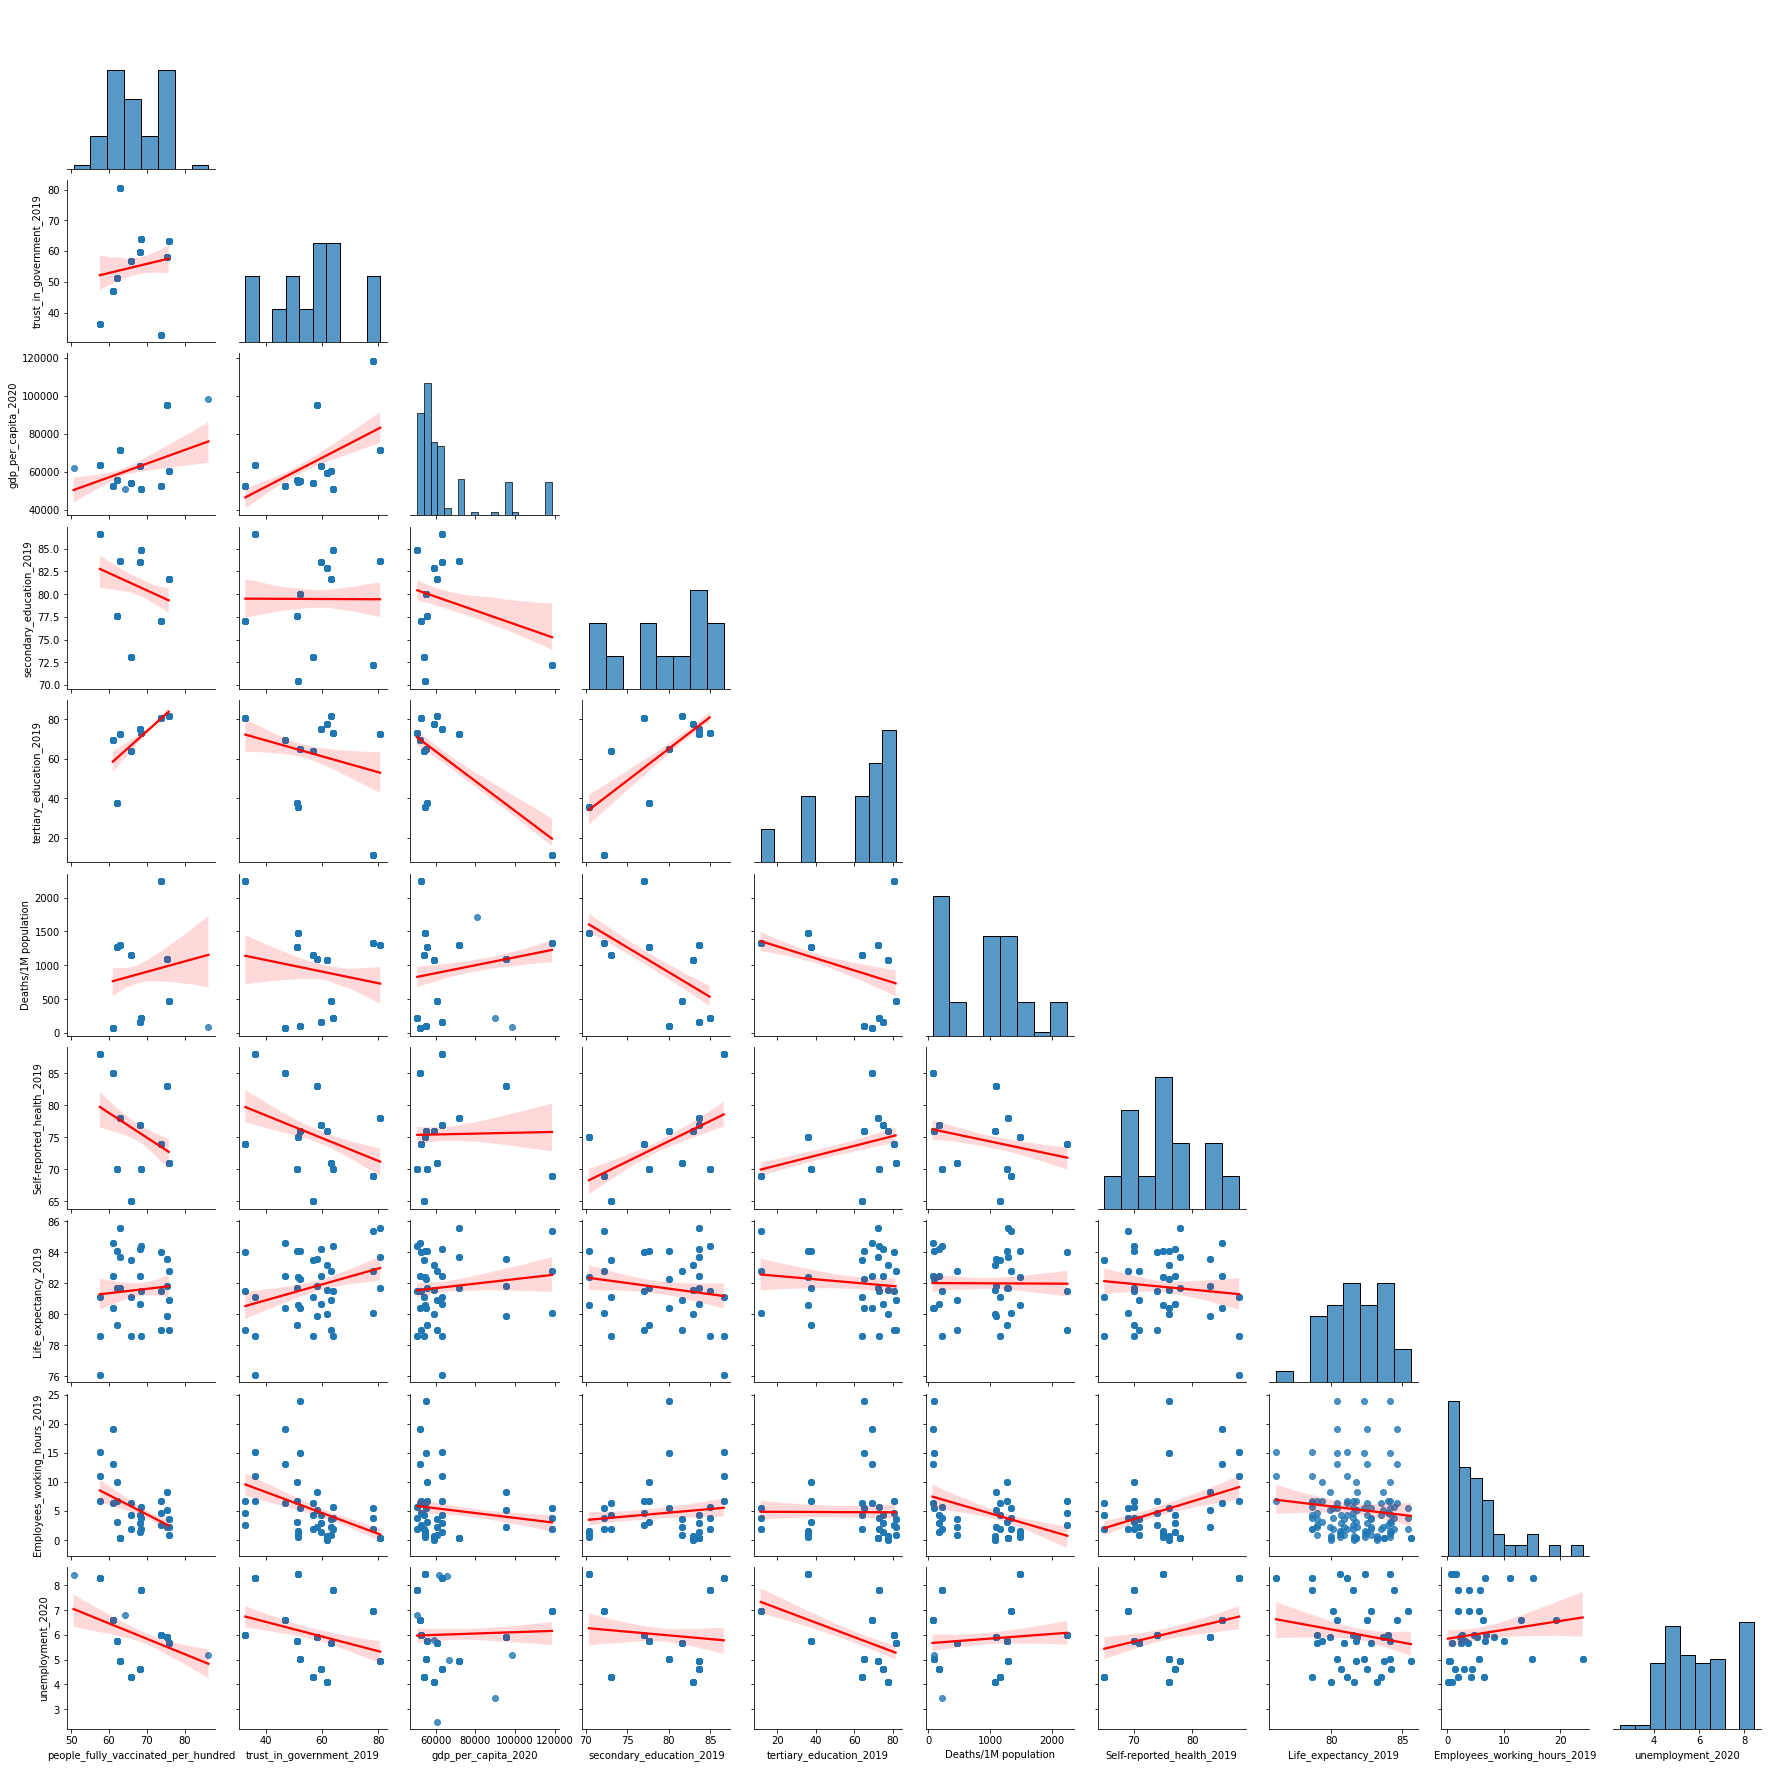

In [42]:
data = data.loc[(data["gdp_per_capita_2020"]>=50000)]
g = sns.pairplot(data, kind="reg", corner=True, plot_kws={'line_kws':{'color':'red'}})
plt.show()